In [44]:
import os
import sys
import time

import numpy as np
import torch
from torch import nn
from torchsummary import summary

from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

class DataPreprocess:
    '''''
        Usage:
            Loads the training and test data, breaks them in tiles and standardizes with respect to the training
            data. The images are textfiles in format .dat (whatever it is)

            DataPreprocess(data_list, tile_size=80, overlap=44, threshold=6)
                Declares a data preprocessing object
                data_list: list of paths to all .dat files.
                tile_size: size of each square tile (e.g., 80 X 80)
                overlap: number of pixels that overlap between adjacent tiles.
                threshold: how "active" a tile must be kept (based on intensity outliers).
                Variables to store images, tiles, standardization stats, etc.

            standardize(self, datatype)
                Standardizes pixel values by subtracting the mean and dividing by the standard deviation.
                - train: computes mean and std from train_tiles.
                - test: applies the training mean and std to normalize test_tiles (this ensures consistency).

            tile_image(self, image)
                Splits a single large 2D image into overlapping tile_size x tile_size tiles.
                - Uses a sliding window with step = tile_size - overlap.
                - Applies a threshold check to discard low-contrast or low-activity tiles:
                    - Computes the median of the tile.
                    - Flags pixels > 3 x median as high.
                    - Keeps tiles with at least threshold such high pixels.

            tile_data(self, datatype)
                - Splits all train_images or test_images into tiles using tile_image.
                - Stores the final tile stack in self.train_tiles or self.test_tiles
                - Records test_image_indexes, which helps group tiles back to their parent images for analysis (e.g., per-image anomaly scoring).

            load(self, datatype, num_data, datalist, randomize=True)
                Loads .dat files from disk and stores them as numpy arrays.
                - datatype: 'train' or 'test'.
                - datalist: a custom list of image paths (optional).
                - num_data: how many images to load ('all' or an integer).
                - If randomize=True, it randomly selects images from the list.
                - After loading, it tiles and standardizes the data.

            Variables:
                train_tiles
                test_tiles
                test_image_indexes: indexes of the first one of the tiles corresponding to each image. For example,
                                    the tiles of image 0 are located in test_tiles in positions test_image[0]
                                    to test_image[1]-1. Useful to compute the reconstruction error of a given
                                    test image

            Other variables:
                list:               Used data list
                train_images
                test_images
                train_loaded:       Boolean
                test_loaded:        Boolean
                train_standardized: Boolean
                test_standardized:  Boolean
                tile_size
                overlap
                threshold
                mean:               standardization mean
                std:                standardization std

            Example usage
                preprocess = DataPreprocess(data_list, tile_size=80, overlap=44, threshold=10)
                preprocess.load('train', num_data=100)     # Loads and tiles 100 images
                train_tiles = preprocess.train_tiles       # Shape: (N_tiles, 80, 80)
    '''''
    def __init__(self, data_list, tile_size=80, overlap=44, threshold=6):
        self.mean = None
        self.std = None
        self.list=data_list
        self.train_loaded=False
        self.test_loaded=False
        self.train_standardized=False
        self.test_standardized=False
        self.tile_size=tile_size
        self.overlap = overlap
        self.step = None
        self.threshold=threshold
        self.train_images = None
        self.test_images = None
        self.train_tiles = None
        self.test_tiles = None
        self.train_file_list = None
        self.test_file_list = None
        self.test_image_indexes = None

    def standardize(self, datatype: str):
        """
        Standardizes the tile data (zero mean, unit variance) using training statistics.
        Parameters:
        - datatype: 'train' or 'test'
        """
        tiles = self.train_tiles if datatype == 'train' else self.test_tiles

        if tiles is None:
            raise ValueError(f"{datatype}_tiles is not loaded yet")

        if datatype == 'train':
            tensor = torch.from_numpy(self.train_tiles).float()
            self.mean = tensor.mean().item()
            self.std = tensor.std().item()
            self.train_tiles = ((tiles - self.mean) / self.std).astype(np.float32)
            self.train_standardized = True

        if datatype == 'test' and self.train_standardized:
            self.test_tiles = ((tiles - self.mean) / self.std).astype(np.float32)
            self.test_standardized = True


    def tile_image(self, image):
        height, width = image.shape[:2]

        if self.step is None:
            self.step = self.tile_size - self.overlap

        # Validating tiling parameters
        valid = (height - self.overlap) % self.step == 0
        if not valid:
            print("The overlaps for a tile size of " + str(self.tile_size) + " can only be:")
            for w in range(1, self.tile_size):
                if (height - w) % (self.tile_size - w) == 0:
                    print(f"    overlap = {w}")
            sys.exit("Please choose a valid overlap value.")

        tiles = []
        for y in range(0, height - self.overlap, self.step):
            for x in range(0, width - self.overlap, self.step):
                tile = image[y:y + self.tile_size, x:x + self.tile_size]
                flat_tile = tile.reshape(-1, 1) # Reshapes the tile into a column vector
                median_val = np.median(flat_tile)
                binary_mask = (flat_tile > 3 * median_val).astype(np.uint8)
                high_value_count = np.sum(binary_mask)

                if high_value_count >= self.threshold:
                    tiles.append(tile)

        return tiles

    def tile_data(self, datatype):
        images = self.train_images if datatype == 'train' else self.test_images
        is_test = (datatype == 'test')

        height, width, num_images = images.shape
        self.step = self.tile_size - self.overlap # how much we move the window each time.
        process_time = AlgorithmTimer(num_images)

        max_tiles_per_image = int(((height - self.overlap) / self.step) ** 2) # an upper-bound guess on how many tiles you'll get per image.
        temp_tiles = np.zeros((max_tiles_per_image * num_images, self.tile_size, self.tile_size)) # a big array to temporarily hold all the tiles
        tile_index = 0 # current write position in temp_tiles
        test_indexes = [0] if is_test else None
        # process_time.restart(num_images)

        for i in range(num_images):
            tiles = self.tile_image(images[:,:,i]) # get a list of 2D tiles.
            num_tiles = len(tiles)
            temp_tiles[tile_index:tile_index + num_tiles] = tiles
            tile_index += num_tiles

            if is_test:
                test_indexes.append(tile_index)

            process_time.show_time("Tiling, "+str(i+1)+"/"+str(num_images)+'('+ str(num_tiles)+ ')')

        print("                                                                                                \r",end='',flush=True)
        print("Number of "+datatype+" tiles: "+str(tile_index))

        if datatype == 'train':
            self.train_tiles = temp_tiles[:tile_index]
        else:
            self.test_tiles = temp_tiles[:tile_index]
            self.test_image_indexes = test_indexes

    def load(self, datatype, num_data: str | int, datalist=None, randomize=True):
        # Select file list
        file_list = self.list if datalist is None else datalist

        # Store the list for reference
        if datatype == 'train':
            self.train_file_list = file_list
        elif datatype == 'test':
            self.test_file_list = file_list
        else:
            raise ValueError("datatype must be 'train' or 'test'")

        if num_data == 'all':
            num_data = len(file_list)

        # Determine image size from first file
        sample_image = np.genfromtxt(file_list[0])
        size = sample_image.shape[0]

        # Select indices to load
        selected_indices = (
            np.random.choice(len(file_list), size=num_data, replace=False)
            if randomize else
            range(num_data)
        )

        # Preallocate image tensor
        images = np.zeros((size,size,num_data))

        # Load selected images
        timer = AlgorithmTimer(num_data)
        for i,idx in enumerate(selected_indices):
            img = np.genfromtxt(file_list[idx])
            images[:,:,i] = img
            timer.show_time('Reading images. ')

        # Save to appropriate field
        if datatype == 'train':
            self.train_images = images
            self.train_loaded=True
        if datatype == 'test':
            self.test_images = images
            self.test_loaded=True

        # Tile and standardize
        self.tile_data(datatype)
        self.standardize(datatype)

class Autoencoder2(nn.Module): #We call this autoencoder 2
    def __init__(self, dropout_rate=0.2):
        super(Autoencoder2, self).__init__()

        self.dropout_rate = dropout_rate
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=5, padding=0),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=4, padding=0),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=4, padding=0),
            nn.ReLU(),

            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            # nn.Sigmoid()
        )

    def forward(self, x):
        xb = self.encoder(x)
        x = self.decoder(xb)
        return x, xb

class AlgorithmTimer:
    def __init__(self, num_iterations):
        self.start_time = None
        self.end_time = None
        self.elapsed_time = None
        self.iteration = 0
        self.total_time = 0
        self.num_iterations = num_iterations
    sround = lambda x,p: float(f'%ds.{p-1}e'%x) # This is to print numbers with a given number od decimals
    def start(self):
        self.start_time = time.time()

    def end(self):
        self.end_time = time.time()
        self.elapsed_time = self.end_time - self.start_time

    def restart(self, num_iterations):
        self.start_time = None
        self.end_time = None
        self.elapsed_time = None
        self.iteration = 0
        self.total_time = 0
        self.num_iterations = num_iterations

    def hms(self,t):
        h=np.floor(t/3600)
        t=t-h*3600
        m=np.min([59,np.floor(t/60)])
        s=np.min([59,t-m*60])
        h_str=f'{h:.0f}'
        m_str=f'{m:.0f}'
        if np.floor(m)<=9:
            m_str=f'0{np.floor(m):.0f}'
        s_str = f'{s:.0f}'
        if np.floor(s)<=9:
            s_str = f'0{np.floor(s):.0f}'
        time_str = h_str + ':' + m_str + ':' + s_str
        return time_str

    def show_time(self, message=''):
        if self.start_time is not None:
            self.iteration=self.iteration+1
            self.end()
            self.total_time=self.total_time+self.elapsed_time
            t=self.elapsed_time
            T=self.num_iterations*self.total_time/self.iteration
            total_time = self.hms(T)
            RT=T-self.total_time
            remaining_time=self.hms(RT)
            print(message + f' Iteration time: {round(t, 2):.2f} s. Total time: ' + total_time + '. Remaining time: ' + remaining_time + '           \r', end='', flush=True)
        self.start()

    def total_time(self):
        if self.start_time is not None:
            return self.total_time
        return None

    def show_total_time(self):
        if self.start_time is not None:
            timestr=self.hms(self.total_time)
            print("Total time: " +timestr+"                                    " )
            return self.total_time
        return None

# Load Data

In [45]:
data_path = 'data'

# List of data
data_list = []
for filename in os.listdir(data_path):
    if filename.endswith(".dat"):
        data_list.append(os.path.join(data_path, filename))

# Data Preprocessing

In [46]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Parameters of the training
tile_size = 80
overlap = 44
threshold = 10
batch_size = 32
input_shape = (tile_size, tile_size, 1)

N_train = 'all'# This is the number of training data (we choose later the first N_train images)
N_test = 'all'
# With N_train = 146 we get 10,000 tiles of 80x80 and overlap 44

# Split the image paths before any processing
train_files, test_files = train_test_split(data_list, test_size=0.2, random_state=42)

# Initialize preprocess object
preprocess = DataPreprocess(data_list=data_list, tile_size=tile_size, overlap=overlap, threshold=threshold)

# Load and process training data
preprocess.load('train', datalist=train_files, num_data=N_train, randomize=True)
train_data = preprocess.train_tiles

# Load and process test data
preprocess.load('test', datalist=test_files, num_data=N_test, randomize=False)
val_data = preprocess.test_tiles

# Convert to PyTorch tensors
train_tensor = torch.tensor(train_data).unsqueeze(1).float()
val_tensor = torch.tensor(val_data).unsqueeze(1).float()

# Build DataLoaders
train_loader = DataLoader(TensorDataset(train_tensor, train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(val_tensor, val_tensor), batch_size=batch_size)

# Define model and training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder2().to(device)
summary(model, input_size=(1, tile_size, tile_size))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss() # loss function

# 8. Train the model and track losses
epochs = 10
train_losses = []
val_losses = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model.train() # set model to training mode
    total_train_loss = 0

    for x, _ in train_loader: # Each x is a batch of image tiles (e.g., 32 of size 1x80x80)
        x = x.to(device) # move to GPU (or CPU if no GPU)
        output, _ = model(x) # Forward
        loss = criterion(output, x)
        # Backpropagation
        optimizer.zero_grad() # Clear previous gradients
        loss.backward() # Backpropagate to compute gradients
        optimizer.step() # Update model weights
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    total_val_loss = 0
    with torch.no_grad(): # saves memory and speeds up evaluation
        for x, _ in val_loader:
            x = x.to(device)
            output, _ = model(x)
            loss = criterion(output, x)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.6f} - Val Loss: {avg_val_loss:.6f}")

val_data = preprocess.test_tiles

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 80, 80]             640
              ReLU-2           [-1, 64, 80, 80]               0
         MaxPool2d-3           [-1, 64, 20, 20]               0
            Conv2d-4          [-1, 128, 20, 20]          73,856
              ReLU-5          [-1, 128, 20, 20]               0
         MaxPool2d-6            [-1, 128, 5, 5]               0
            Conv2d-7            [-1, 256, 5, 5]         295,168
              ReLU-8            [-1, 256, 5, 5]               0
         MaxPool2d-9            [-1, 256, 1, 1]               0
  ConvTranspose2d-10            [-1, 128, 5, 5]         819,328
             ReLU-11            [-1, 128, 5, 5]               0
  ConvTranspose2d-12           [-1, 64, 20, 20]         131,136
             ReLU-13           [-1, 64, 20, 20]               0
  ConvTranspose2d-14           [-1, 32,

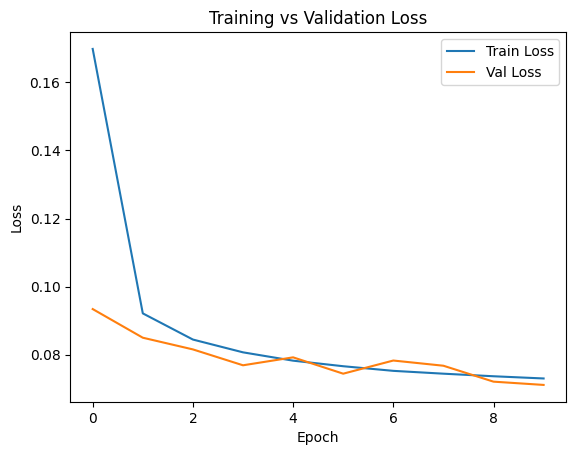

In [47]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

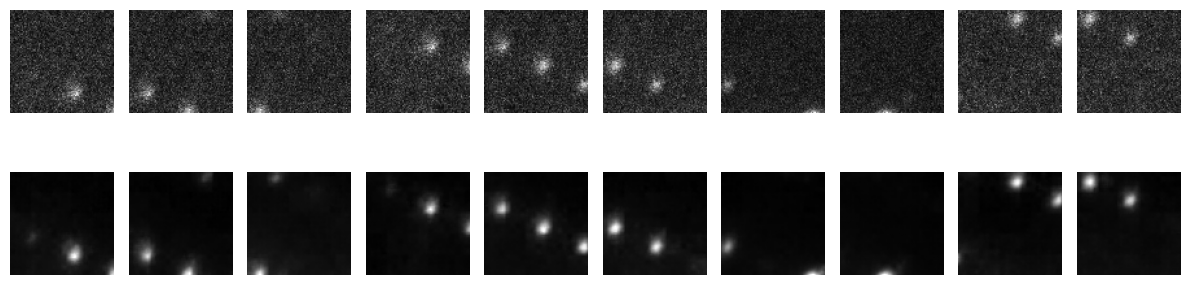

In [48]:
import matplotlib.pyplot as plt

# Use model in eval mode
model.eval()

# Take a batch from validation set
with torch.no_grad():
    val_batch = next(iter(val_loader))[0].to(device)
    reconstructed, _ = model(val_batch)

# Move to CPU for plotting
original = val_batch.cpu().numpy()
reconstructed = reconstructed.cpu().numpy()

# Plot first 6 tiles
n = 10
plt.figure(figsize=(12, 4))
for i in range(n):
    # Original
    plt.subplot(2, n, i + 1)
    plt.imshow(original[i][0], cmap='gray')
    # plt.title("Original")
    plt.axis('off')

    # Reconstructed
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i][0], cmap='gray')
    # plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [70]:
import matplotlib.pyplot as plt

# val_tensor: shape (N, 1, 80, 80) from validation
model.eval()
with torch.no_grad():
    recon_batch, _ = model(val_tensor.to(device))
    recon_batch = recon_batch.cpu().numpy()
    original = val_tensor.cpu().numpy()


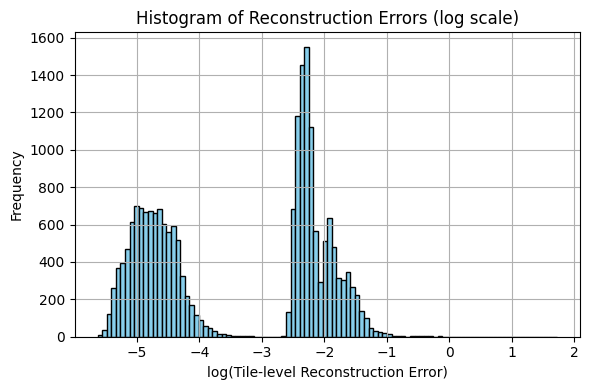

In [71]:
# Compute MSE per tile (reconstruction error)
errors = ((original - recon_batch) ** 2).mean(axis=(1, 2, 3))  # shape: (N,)
log_errors = np.log(errors)

# Plot histogram (e.g., 100 bins)
plt.figure(figsize=(6, 4))
plt.hist(log_errors, bins=100, color='skyblue', edgecolor='black')
plt.xlabel('log(Tile-level Reconstruction Error)')
plt.ylabel('Frequency')
plt.title('Histogram of Reconstruction Errors (log scale)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
image_indexes = preprocess.test_image_indexes  # e.g., [0, 34, 67, ..., total_tiles]
reconstruction_errors = ((original - recon_batch) ** 2).mean(axis=(1, 2, 3))  # shape: (N_tiles,)
image_level_errors = []

for i in range(len(image_indexes)-1):
    start = image_indexes[i]
    end = image_indexes[i+1]
    mean_error = reconstruction_errors[start:end].mean()
    image_level_errors.append(np.log(mean_error))  # log(MSE)

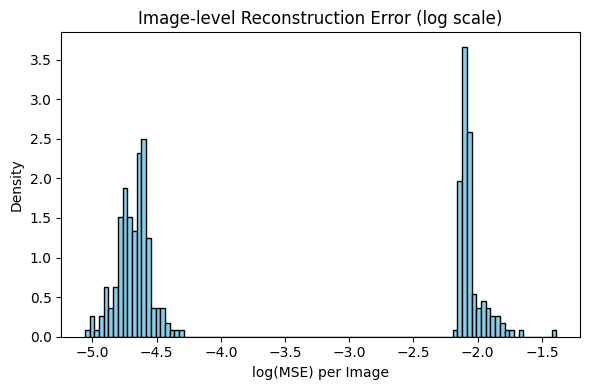

In [52]:
plt.figure(figsize=(6, 4), facecolor='white')  # Set figure background
ax = plt.gca()
ax.set_facecolor('white')  # Set axes background

plt.hist(image_level_errors, bins=100, density=True, edgecolor='black', color='skyblue')
plt.xlabel('log(MSE) per Image')
plt.ylabel('Density')
plt.title('Image-level Reconstruction Error (log scale)')
plt.tight_layout()
plt.show()

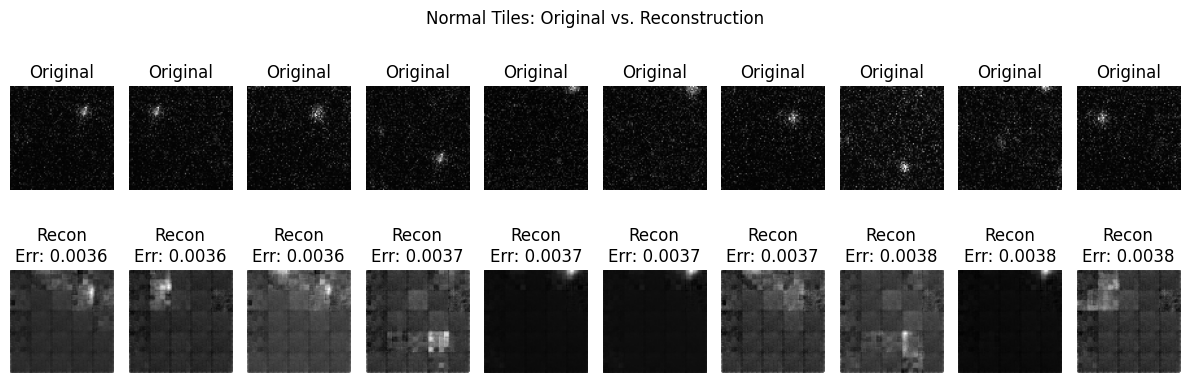

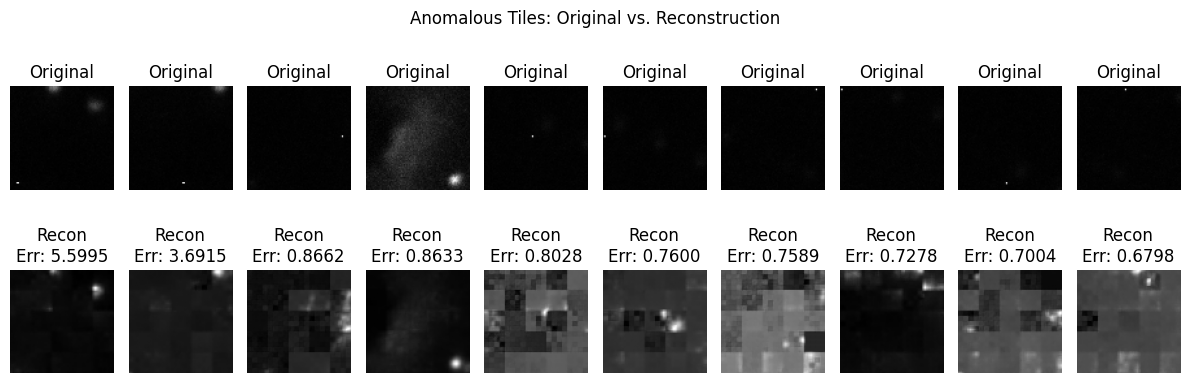

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Compute reconstruction errors
reconstruction_errors = ((original - recon_batch) ** 2).mean(axis=(1, 2, 3))

# Get indices for best (normal) and worst (anomalous) reconstructions
k = 10
normal_indices = np.argsort(reconstruction_errors)[:k]
anomaly_indices = np.argsort(reconstruction_errors)[-k:]

# Plot normal tiles
plt.figure(figsize=(12, 4))
for i, idx in enumerate(normal_indices):
    # Original
    plt.subplot(2, k, i + 1)
    plt.imshow(original[idx][0], cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed
    plt.subplot(2, k, i + 1 + k)
    plt.imshow(recon_batch[idx][0], cmap='gray')
    plt.title(f"Recon\nErr: {reconstruction_errors[idx]:.4f}")
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Normal Tiles: Original vs. Reconstruction", y=1.05)
plt.show()

# Plot anomalous tiles
plt.figure(figsize=(12, 4))
for i, idx in enumerate(anomaly_indices[::-1]):
    # Original
    plt.subplot(2, k, i + 1)
    plt.imshow(original[idx][0], cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed
    plt.subplot(2, k, i + 1 + k)
    plt.imshow(recon_batch[idx][0], cmap='gray')
    plt.title(f"Recon\nErr: {reconstruction_errors[idx]:.4f}")
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Anomalous Tiles: Original vs. Reconstruction", y=1.05)
plt.show()


In [77]:
from scipy.stats import norm
import numpy as np

# Focus on normal-looking errors (left peak)
normal_log_errors = np.array(image_level_errors)
normal_log_errors = normal_log_errors[normal_log_errors < -3.5]  # adjust cutoff if needed

# Fit normal distribution
mu, sigma = norm.fit(normal_log_errors)

# Function to get anomaly score
def anomaly_score(log_mse, mu, sigma):
    return norm.cdf(log_mse, loc=mu, scale=sigma)

# Calculate probabilities
probs = anomaly_score(np.array(image_level_errors), mu, sigma)

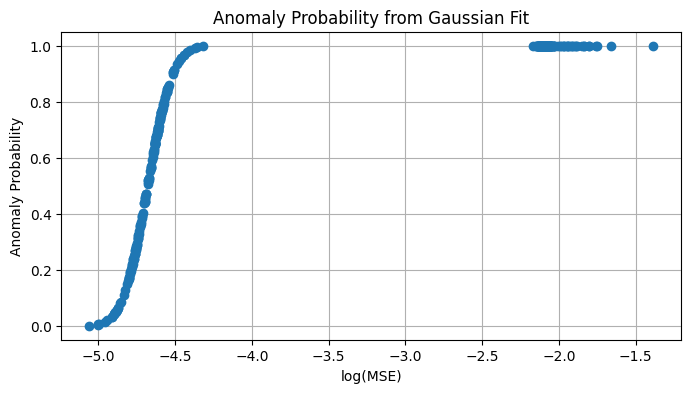

In [79]:
log_mse_vals = np.array(image_level_errors)

plt.figure(figsize=(8, 4))
plt.plot(log_mse_vals, probs, 'o')
plt.xlabel("log(MSE)")
plt.ylabel("Anomaly Probability")
plt.title("Anomaly Probability from Gaussian Fit")
plt.grid(True)
plt.show()


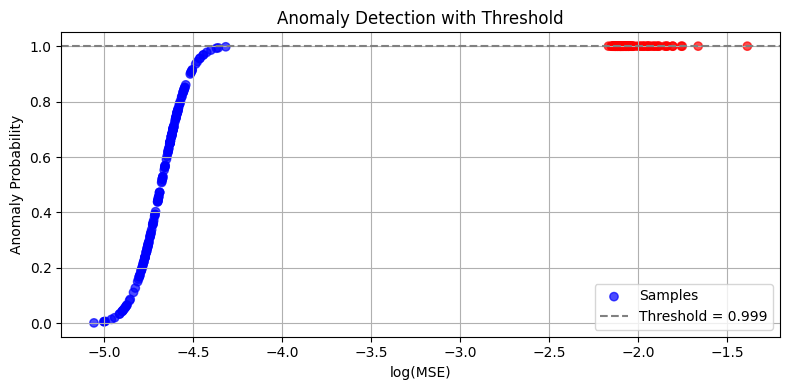

In [86]:
import matplotlib.pyplot as plt

log_mse_vals = np.array(image_level_errors)
probs = anomaly_score(log_mse_vals, mu, sigma)

threshold = 0.999
colors = ['red' if p >= threshold else 'blue' for p in probs]

sorted_idx = np.argsort(log_mse_vals)
log_mse_sorted = log_mse_vals[sorted_idx]
probs_sorted = probs[sorted_idx]
colors_sorted = np.array(colors)[sorted_idx]

plt.figure(figsize=(8, 4))
plt.scatter(log_mse_sorted, probs_sorted, c=colors_sorted, alpha=0.7, label='Samples')
plt.axhline(threshold, color='gray', linestyle='--', label=f'Threshold = {threshold}')
plt.xlabel("log(MSE)")
plt.ylabel("Anomaly Probability")
plt.title("Anomaly Detection with Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [87]:
n_total = len(probs)
n_anomaly = np.sum(probs >= threshold)
n_normal = n_total - n_anomaly

print(f"Total images: {n_total}")
print(f"Predicted anomalies: {n_anomaly}")
print(f"Predicted normals: {n_normal}")


Total images: 305
Predicted anomalies: 124
Predicted normals: 181
